# **(ADD HERE THE NOTEBOOK NAME)**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector'

# Section 1

Section 1 content

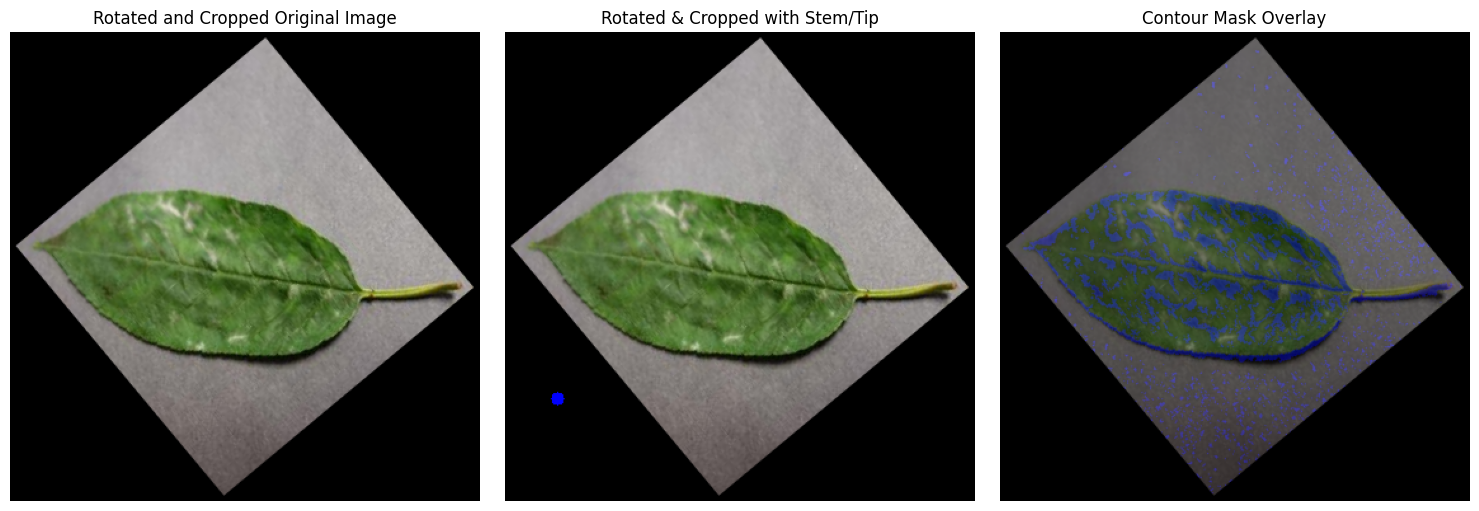

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rotate_image(image, angle):
  rows, cols = image.shape[:2]
  rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
  return cv2.warpAffine(image, rotation_matrix, (cols, rows))

def correct_orientation_tip_stem(image, block_size_green=11, c_green=2, block_size_sat=11, c_sat=2, adaptive_method=cv2.ADAPTIVE_THRESH_MEAN_C):
    # 1. Extract green channel and apply threshold
    green_channel = image[:, :, 1]
    thresh_green = cv2.adaptiveThreshold(green_channel, 255, adaptive_method, cv2.THRESH_BINARY_INV, block_size_green, c_green)

    # 2. Extract saturation channel and apply threshold
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    saturation_channel = hsv_image[:, :, 1]
    thresh_saturation = cv2.adaptiveThreshold(saturation_channel, 255, adaptive_method, cv2.THRESH_BINARY, block_size_sat, c_sat)

    # 3. Combine Masks
    thresh = cv2.bitwise_and(thresh_green, thresh_saturation)


    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image, None, None, thresh, None, None # return original image if no contours found

    largest_contour = max(contours, key=cv2.contourArea)

    # Find the rotated bounding box
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Calculate the centroid of the contour
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
       cx = int(M["m10"] / M["m00"])
       cy = int(M["m01"] / M["m00"])
    else:
       return image, None, None, thresh, None, None # return original image if no centroid

    # The points of the bounding box
    # Find the angle of the bounding box and adjust accordingly.
    angle = rect[-1]

    # adjust the angle to be between -90 and 90
    if angle > 45:
        angle = angle - 90
    elif angle < -45:
        angle = angle + 90

    # 1. Pad the image to add space for rotation
    padding = max(image.shape[:2]) # Make sure to pad equally to create a square
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0,0,0])
    padded_thresh = cv2.copyMakeBorder(thresh, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0])

    # Rotate the image and threshold image
    rotated_image = rotate_image(padded_image, -angle)
    rotated_thresh = rotate_image(padded_thresh, -angle)

    # Calculate the rotated points
    rotation_matrix = cv2.getRotationMatrix2D((padded_image.shape[1] / 2, padded_image.shape[0] / 2), -angle, 1)
    rotated_box = cv2.transform(np.array([box], dtype=np.float32), rotation_matrix).squeeze()

    # Calculate the centroid of the rotated box
    rotated_M = cv2.moments(cv2.convexHull(rotated_box))
    if rotated_M["m00"] != 0:
       rotated_cx = int(rotated_M["m10"] / rotated_M["m00"])
       rotated_cy = int(rotated_M["m01"] / rotated_M["m00"])
    else:
       return rotated_image, None, None, rotated_thresh, None, None

    # Project onto major axis
    # We can approximate the major axis through rotated_cy and perpendicular to the sides of the bounding box
    # For a vertical rotated box, this can be approximated by using the y-coordinates of the box
    y_coords = sorted([x[1] for x in rotated_box])
    stem_point = (rotated_cx, y_coords[0])
    tip_point = (rotated_cx, y_coords[-1])

    # check the widths of the leaf to refine stem and tip assignment - we do this by summing the contour at the points
    height = abs(stem_point[1] - tip_point[1])
    stem_sum = 0
    tip_sum = 0
    
    # Check if the points are within the image bounds, and if not adjust the index
    rows, cols = rotated_thresh.shape[:2]

    for i in range(-10, 10):
        tip_y = int(tip_point[1]) + i
        stem_y = int(stem_point[1]) + i
        if 0 <= tip_y < rows and 0 <= int(tip_point[0]) < cols:
            tip_sum = tip_sum +  rotated_thresh[tip_y][int(tip_point[0])]
        if 0 <= stem_y < rows and 0 <= int(stem_point[0]) < cols:
           stem_sum = stem_sum +  rotated_thresh[stem_y][int(stem_point[0])]
        
    # if the width of the stem is smaller, swap
    if stem_sum < tip_sum:
        stem_point, tip_point = tip_point, stem_point

    # 3. Crop to the bounding box of the rotated leaf
    rotated_gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
    rotated_thresh_crop = cv2.adaptiveThreshold(rotated_gray, 255, adaptive_method, cv2.THRESH_BINARY_INV, block_size_green, c_green)
    contours, _ = cv2.findContours(rotated_thresh_crop, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return rotated_image, tip_point, stem_point, rotated_thresh, None, None # return original image if no contours found

    largest_contour_crop = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour_crop)
    
    # Calculate dimensions for square crop
    max_dim = max(w, h)
    center_x = x + w // 2
    center_y = y + h // 2
    crop_x = center_x - max_dim // 2
    crop_y = center_y - max_dim // 2

    # Adjust crop boundaries
    rows, cols = rotated_image.shape[:2]
    if crop_x < 0:
        crop_x = 0
    if crop_y < 0:
        crop_y = 0
    if crop_x + max_dim > cols:
        crop_x = cols - max_dim
    if crop_y + max_dim > rows:
        crop_y = rows - max_dim

    # Perform the square crop
    cropped_rotated_image = rotated_image[crop_y:crop_y + max_dim, crop_x:crop_x + max_dim]
    cropped_rotated_thresh = rotated_thresh[crop_y:crop_y + max_dim, crop_x:crop_x + max_dim]
    
    return cropped_rotated_image, tip_point, stem_point, cropped_rotated_thresh, (crop_x, crop_y, max_dim), angle

def visualize_with_mask(image_path, block_size_green=11, c_green=2, block_size_sat=11, c_sat=2, adaptive_method=cv2.ADAPTIVE_THRESH_MEAN_C):
    # Load image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: could not read image at {image_path}")
        return

    # Apply orientation and get results, mask, bounding box
    rotated_image, tip, stem, mask, crop_params, angle = correct_orientation_tip_stem(original_image.copy(), block_size_green, c_green, block_size_sat, c_sat, adaptive_method)
    if tip is None or stem is None or crop_params is None:
        print("Error: no stem or tip or crop detected")
        return
    
    crop_x, crop_y, max_dim = crop_params
    
    # rotate the original image
    padding = max(original_image.shape[:2]) # Make sure to pad equally to create a square
    padded_image = cv2.copyMakeBorder(original_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0,0,0])
    rotated_image_orig = rotate_image(padded_image, -angle)

    # crop original image
    cropped_rotated_image_orig = rotated_image_orig[crop_y:crop_y + max_dim, crop_x:crop_x + max_dim]

    # Prepare image for overlay
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) # convert to 3 channel for overlay
    mask_color[:, :, 1] = 0
    mask_color[:, :, 2] = 0  # make mask red

    # Create the overlay
    mask_overlay = cv2.addWeighted(cropped_rotated_image_orig, 0.6, mask_color, 0.4, 0)

    # Convert tip and stem to integer tuples
    tip_int = (int(tip[0]), int(tip[1]))
    stem_int = (int(stem[0]), int(stem[1]))

    rotated_image_display = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
    rotated_image_display = cv2.circle(rotated_image_display, tip_int, 5, (255, 0, 0), -1)
    rotated_image_display = cv2.circle(rotated_image_display, stem_int, 5, (0, 0, 255), -1)

    # Display the images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cropped_rotated_image_orig, cv2.COLOR_BGR2RGB))
    plt.title('Rotated and Cropped Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rotated_image_display)
    plt.title('Rotated & Cropped with Stem/Tip')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(mask_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Contour Mask Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (replace with a single image)
sample_image_path = "inputs/datasets/raw/cherry-leaves/test/powdery_mildew/f7f8411d-93f5-4fd7-bf9a-9759cf6acd8b___FREC_Pwd.M 4466.JPG"  # Replace with a test image path
visualize_with_mask(sample_image_path, block_size_green=15, c_green=7, block_size_sat=15, c_sat=7, adaptive_method=cv2.ADAPTIVE_THRESH_MEAN_C)

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
